In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
%matplotlib inline
from jax.nn import sigmoid, log_sigmoid

In [2]:
N = 1000
K = 10

np.random.seed(2)

X = np.random.randn(N, K)
beta_true = np.random.randn(K)
gamma_true = np.random.normal()

logit_true = X @ beta_true + gamma_true

y = np.random.uniform(size=N) < sigmoid(logit_true)

In [3]:
import pystan
from stan_utils import load_stan_model_cached

# Fit this with Stan

model_data = {
    'X': X,
    'y': y.astype(int),
    'N': N,
    'K': K
}

stan_model = load_stan_model_cached('./stan_log_reg.stan')

/home/martin/miniconda3/envs/jax/lib/python3.7/site-packages/jax/lax/lax.py:6188: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [4]:
fit_result = stan_model.sampling(data=model_data)

In [5]:
print(fit_result)

Inference for Stan model: anon_model_13e2503bce983084faaf24120f53644d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]   -0.83  1.3e-3    0.1  -1.03   -0.9  -0.83  -0.76  -0.64   5795    1.0
beta[2]   -0.45  1.1e-3    0.1  -0.64  -0.51  -0.45  -0.38  -0.26   7425    1.0
beta[3]   -0.34  1.0e-3   0.09  -0.52   -0.4  -0.34  -0.28  -0.16   7626    1.0
beta[4]   -0.34  1.1e-3   0.09  -0.53   -0.4  -0.34  -0.28  -0.16   6941    1.0
beta[5]   -1.72  1.9e-3   0.13  -1.98  -1.81  -1.72  -1.63  -1.47   4791    1.0
beta[6]    0.56  1.2e-3    0.1   0.37    0.5   0.56   0.63   0.76   7179    1.0
beta[7]   -0.81  1.3e-3    0.1  -1.01  -0.87  -0.81  -0.74  -0.61   5731    1.0
beta[8]    0.15  9.4e-4   0.09  -0.02   0.09   0.15   0.21   0.32   8537    1.0
beta[9]   -1.42  1.8e-3   0.12  -1.65   -1.5  -1.41  -1.33  -1.19   4726    1.0
beta[10]  -

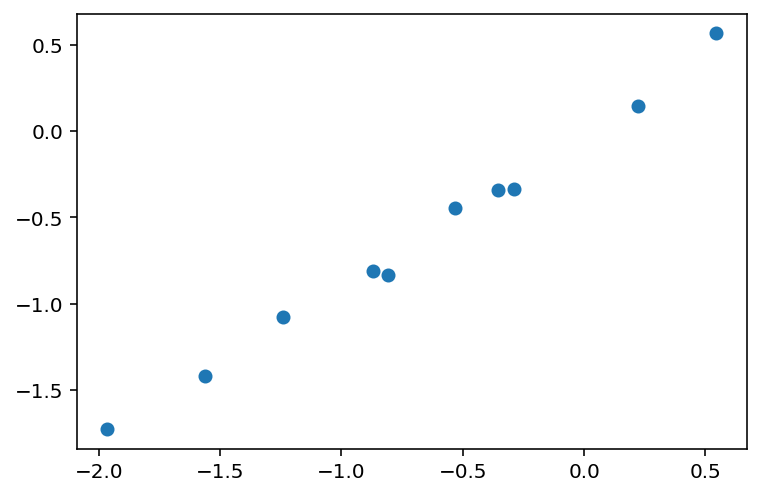

In [6]:
plt.scatter(beta_true, fit_result['beta'].mean(axis=0))

In [7]:
gamma_true

0.25193706697790286

In [8]:
from jax_advi.advi import optimize_advi_mean_field
from jax import jit
from jax.scipy.stats import norm

In [9]:
# Try ADVI
theta_shapes = {
    'beta': (K),
    'gamma': ()
}

In [10]:
def calculate_likelihood(theta, X, y):
    
    logit_prob = X @ theta['beta'] + theta['gamma']
    
    prob_pres = log_sigmoid(logit_prob)
    prob_abs = log_sigmoid(-logit_prob)
    
    return jnp.sum(y * prob_pres + (1 - y) * prob_abs)

def calculate_prior(theta):
    
    beta_prior = jnp.sum(norm.logpdf(theta['beta']))
    gamma_prior = jnp.sum(norm.logpdf(theta['gamma']))
    
    return beta_prior + gamma_prior

In [11]:
from functools import partial

In [12]:
log_lik_fun = jit(partial(calculate_likelihood, X=X, y=y))
log_prior_fun = jit(calculate_prior)

In [13]:
result = optimize_advi_mean_field(theta_shapes, log_prior_fun, log_lik_fun, n_draws=None)

In [14]:
result

{'free_means': {'beta': array([-0.82330244, -0.44702063, -0.33961162, -0.35089681, -1.70637769,
          0.5537248 , -0.80552737,  0.14856206, -1.42315644, -1.06536627]),
  'gamma': array(0.30978381)},
 'free_sds': {'beta': DeviceArray([0.09989432, 0.09379735, 0.09851588, 0.09609033, 0.11004268,
               0.09300599, 0.08662852, 0.0954992 , 0.09974134, 0.08704781],            dtype=float32),
  'gamma': DeviceArray(0.09317145, dtype=float32)},
 'opt_result':       fun: array(418.88653564)
  hess_inv: <22x22 LbfgsInvHessProduct with dtype=float64>
       jac: array([ 1.15862787e-02, -6.51896000e-03, -1.39382482e-02,  2.89817452e-02,
        -4.18293476e-03,  1.11705661e-02,  1.67015195e-03, -6.31770492e-03,
        -3.96460295e-03,  2.61396170e-03, -8.18994641e-03, -3.63898277e-03,
         3.94582748e-04, -1.74283981e-03,  8.38041306e-05,  6.60419464e-05,
        -1.14601851e-03,  4.92000580e-03, -2.22158432e-03,  3.65269184e-03,
         2.61569023e-03, -3.64798307e-03])
   messa

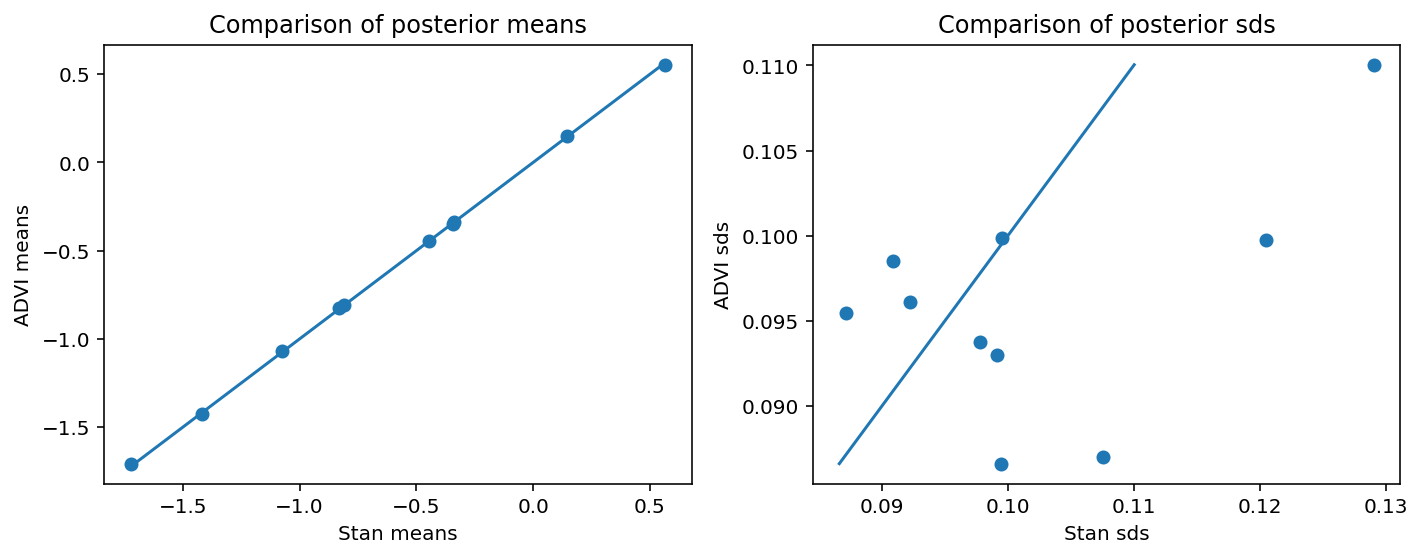

In [15]:
f, ax = plt.subplots(1, 2)

ax[0].scatter(fit_result['beta'].mean(axis=0), result['free_means']['beta'])

ax[0].plot([result['free_means']['beta'].min(), result['free_means']['beta'].max()],
           [result['free_means']['beta'].min(), result['free_means']['beta'].max()])

ax[1].scatter(fit_result['beta'].std(axis=0), result['free_sds']['beta'])
ax[1].plot([result['free_sds']['beta'].min(), result['free_sds']['beta'].max()],
              [result['free_sds']['beta'].min(), result['free_sds']['beta'].max()])

ax[0].set_title('Comparison of posterior means')
ax[1].set_title('Comparison of posterior sds')

ax[0].set_xlabel('Stan means')
ax[0].set_ylabel('ADVI means')

ax[1].set_xlabel('Stan sds')
ax[1].set_ylabel('ADVI sds')

f.set_size_inches(10, 4)
f.tight_layout()

plt.savefig('logistic_reg_comparison.png', dpi=300)

In [21]:
# LRVB
from jax_advi.lrvb import compute_lrvb_covariance, get_posterior_draws_lrvb

lrvb_free_sds, lrvb_cov_mat = compute_lrvb_covariance(
    result['final_var_params_flat'], result['objective_fun'], result['shape_summary'])

100%|██████████| 11/11 [00:02<00:00,  5.46it/s]


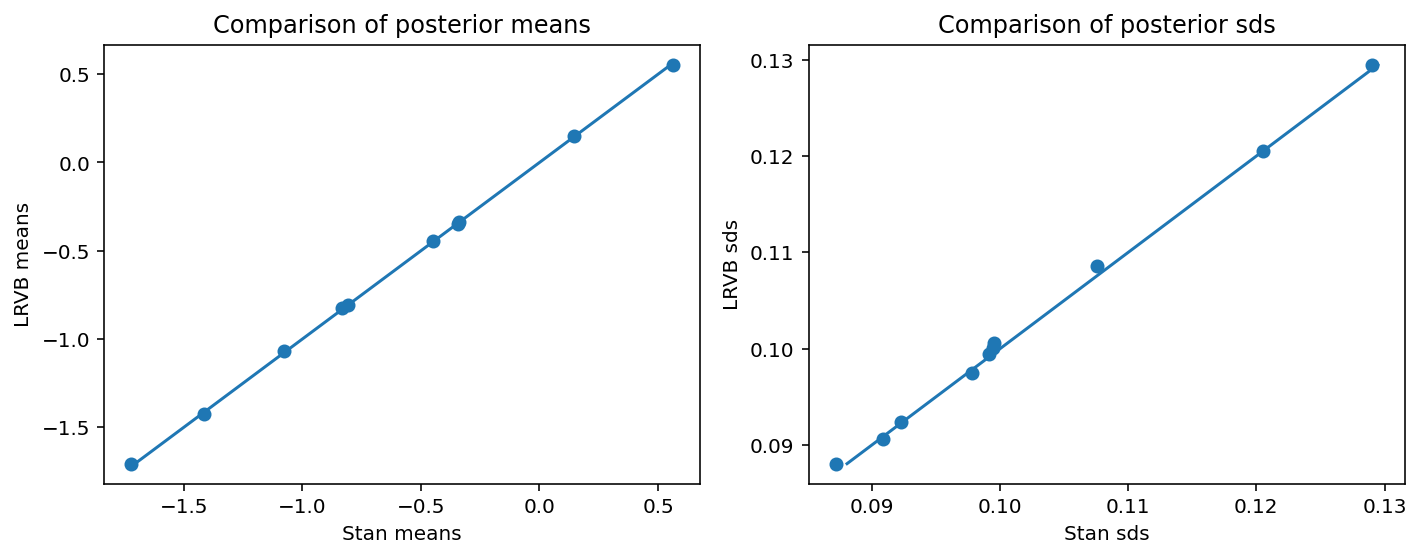

In [22]:
f, ax = plt.subplots(1, 2)

ax[0].scatter(fit_result['beta'].mean(axis=0), result['free_means']['beta'])

ax[0].plot([result['free_means']['beta'].min(), result['free_means']['beta'].max()],
           [result['free_means']['beta'].min(), result['free_means']['beta'].max()])

ax[1].scatter(fit_result['beta'].std(axis=0), lrvb_free_sds['beta'])
ax[1].plot([lrvb_free_sds['beta'].min(), lrvb_free_sds['beta'].max()],
            [lrvb_free_sds['beta'].min(), lrvb_free_sds['beta'].max()])

ax[0].set_title('Comparison of posterior means')
ax[1].set_title('Comparison of posterior sds')

ax[0].set_xlabel('Stan means')
ax[0].set_ylabel('LRVB means')

ax[1].set_xlabel('Stan sds')
ax[1].set_ylabel('LRVB sds')

f.set_size_inches(10, 4)
f.tight_layout()

plt.savefig('logistic_reg_comparison_lrvb.png', dpi=300)